Experimental Identification of Physically Feasible Dynamic Parameters of the 7-link WAM™ Robot using LMI–SDP Techniques
=======================================================================================================================

[![DOI](https://zenodo.org/badge/920/cdsousa/wam7_dyn_ident.png)](http://dx.doi.org/10.5281/zenodo.10537)

*Experimental code and data associated with the paper:*

**Cristóvão D. Sousa and Rui Cortesão, "Physical feasibility of robot base inertial parameter identification: A linear matrix inequality approach," The International Journal of Robotics Research, vol. 33, no. 6, pp. 931–944, May. 2014, doi: [10.1177/0278364913514870](http://dx.doi.org/10.1177/0278364913514870)**

[Postprint availabe from ResearchGate](http://www.researchgate.net/publication/262483999_Physical_feasibility_of_robot_base_inertial_parameter_identification_A_linear_matrix_inequality_approach)

------------------------


Authors
-------

- Cristóvão D. Sousa, [crisjss@gmail.com](mailto:crisjss@gmail.com)
- Rui Cortesão, [cortesao@isr.uc.pt](mailto:cortesao@isr.uc.pt)

------------------------


Research Notebook
-----------------

The research is done in [Python](http://www.python.org/) within an [IPython notebook](http://ipython.org/notebook.html) (the *WAM7 Dynamic Parameter Identification.ipynb* file).
Data is in *data* folder. Additional Python support code is in *support_funcs* folder.

The file *WAM7 Dynamic Parameter Identification.html* is a **preview** of the notebook. **It can be seen online at:**

**[Experimental WAM Robot Dynamic Identification with LMI](http://goo.gl/dOPj8j)**



How to run the code
-------------------

- clone the git repository (it contains code and data) from https://github.com/cdsousa/wam7_dyn_ident
- open the *WAM7 Dynamic Parameter Identification.ipynb* notebook with [IPython](http://ipython.org/)
- edit and run the code

Dependencies:

- [Python](http://www.python.org/)
- [IPython](http://ipython.org/)
- [SymPy](http://sympy.org/)
- [Numpy](http://www.numpy.org/)
- [SciPy](http://www.scipy.org/)
- [SymPyBotics](https://github.com/cdsousa/SymPyBotics)
- [PyLMI-SDP](https://github.com/cdsousa/PyLMI-SDP)

------------------------


Questions & Feedback
--------------------

Feel free to contact the authors at [crisjss@gmail.com](mailto:crisjss@gmail.com)

------------------------


License
-------

Copyright (c) 2013, Cristóvão Duarte Sousa, Rui Cortesão

All rights reserved.

[![Creative Commons License](http://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png)](http://creativecommons.org/licenses/by-nc-sa/4.0/)
This work is licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-nc-sa/4.0/)


---------------

---------------

---------------

---------------

# Initializations

In [2]:
datafolder = 'data/'
tmpfolder = 'tmp/'

In [3]:
from sympy import init_printing
init_printing()

%pylab inline

Populating the interactive namespace from numpy and matplotlib


1 - Robot Model
===============

In [4]:
import sympybotics

#### Robot Definition

In [26]:
rbtdef = sympybotics.RobotDef("onedof",
            [(0, 0, 0, "q")
             ],
            dh_convention="mdh")

rbtdef.gravityacc = sympy.Matrix([0.,9.81,0.])
rbtdef.frictionmodel = {}

#### Model Generation

In [27]:
%time rbt = sympybotics.RobotDynCode(rbtdef)
%time rbt.calc_base_parms()

CPU times: user 134 ms, sys: 26.2 ms, total: 160 ms
Wall time: 139 ms
CPU times: user 366 ms, sys: 6.49 ms, total: 373 ms
Wall time: 248 ms


In [28]:
import pickle
with open(tmpfolder + 'robotmodels/onedof_model.pkl', 'wb') as file:
    pickle.dump( rbt, file )

## Base Dynamic Parameters

In [29]:
import pickle
with open(tmpfolder +  'robotmodels/onedof_model.pkl', 'rb' ) as file:
          rbt = pickle.load( file )

In [30]:
rbt.dyn.n_dynparms, rbt.dyn.n_base

(10, 3)

In [31]:
rbt.dyn.baseparms.n()

Matrix([
[L_1zz],
[ l_1x],
[ l_1y]])

In [32]:
rbt.dyn.Pb

Matrix([
[0, 0, 0],
[0, 0, 0],
[0, 0, 0],
[0, 0, 0],
[0, 0, 0],
[1, 0, 0],
[0, 1, 0],
[0, 0, 1],
[0, 0, 0],
[0, 0, 0]])

In [33]:
idyn_func_def = sympybotics.robotcodegen.robot_code_to_func( 'python', rbt.invdyn_code, 'idyn', 'idyn_func', rbt.rbtdef)
print idyn_func_def

def idyn_func(parms, q, dq, ddq):
#
    idyn = [0]*1
#

    idyn[0] = ddq[0]*parms[5] - 9.81*parms[6]*cos(q[0]) + 9.81*parms[7]*sin(q[0])
#
    return idyn


In [40]:
from sympybotics._compatibility_ import exec_

l = locals()
exec_(idyn_func_def, globals(), l)

tau_onedof = l['idyn_func']


In [41]:
import yaml, sympy
with open(datafolder + 'robotparams/onedof_cad.yml', 'r') as f:
    onedof_cad = yaml.load(f)
dynparm_test = sympy.Matrix([onedof_cad.get(str(d), d) for d in rbt.dyn.dynparms])

In [284]:
import numpy as np

q_test = [2.62074682]#[90*np.pi/180.]
dq_test = [-0.60085045]#[0*np.pi/180.]
ddq_test = [(-0.62453592+0.60085045)/0.02]#[0*np.pi/180.]

In [285]:
tau1 = tau_onedof(dynparm_test, q_test, dq_test, ddq_test)
tau1

[-6.86281899204302]

2 - Excited Trajectory Optimization
==================================

In [97]:
import pickle
with open(tmpfolder +  'robotmodels/onedof_model.pkl', 'rb' ) as file:
          rbt = pickle.load( file )

In [98]:
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from numpy import deg2rad



base_freq = 0.05
fourier_order = 6

joint_constraints = []
cartesian_constraints = []


joint_constraints = [(1, deg2rad(-180), deg2rad(180), deg2rad(-120), deg2rad(120))
                     ]

    
traj_optimizer = TrajOptimizer(rbt, fourier_order, base_freq,
                               joint_constraints=joint_constraints,
                               cartesian_constraints = cartesian_constraints)
                                                                                                 
                                                                                                                     
traj_optimizer.optimize()

joint constraint number: 1
cartesian constraint number: 0
constraint number: 4
frames_constrained: []
cond: 1.88045819568
cond: 1.88045825456
cond: 1.8804584535
cond: 1.88045841218
cond: 1.88045817581
cond: 1.88045817701
cond: 1.88045819404
cond: 1.8804582662
cond: 1.88045859342
cond: 1.88045857351
cond: 1.88045827068
cond: 1.88045809714
cond: 1.8804583057
cond: 1.88045799619
cond: 2.07210967572
cond: 2.07210971058
cond: 2.07211038235
cond: 2.07210895908
cond: 2.07210962998
cond: 2.07210887146
cond: 2.072109898
cond: 2.07210967277
cond: 2.07210620238
cond: 2.07210972263
cond: 2.07210926331
cond: 2.07210966586
cond: 2.07210981659
cond: 2.07211018735
cond: 1.55864502507
cond: 1.55864495166
cond: 1.55864373501
cond: 1.55864500167
cond: 1.55864498921
cond: 1.55864478079
cond: 1.55864414887
cond: 1.55864470509
cond: 1.55864542183
cond: 1.55864543103
cond: 1.55864495117
cond: 1.55864424948
cond: 1.55864498892
cond: 1.5586442679
cond: 1.33385394258
cond: 1.33385393053
cond: 1.33385501713
cond

## plot excited trajectory

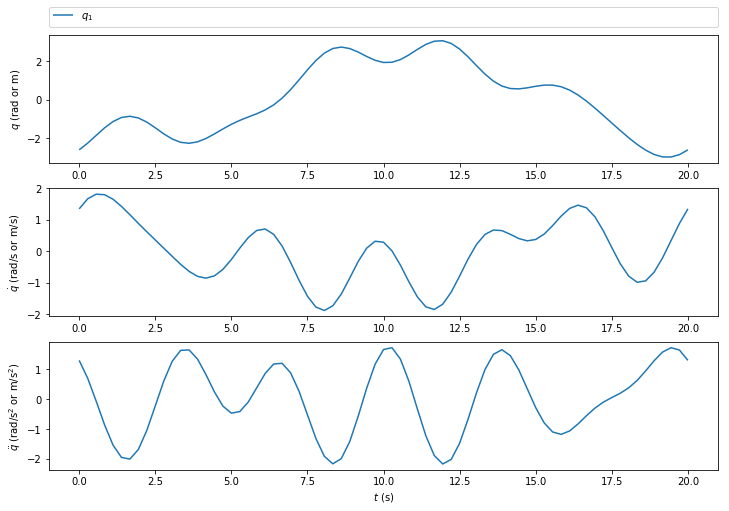

In [99]:
# %matplotlib qt 

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,8]

traj_plotter = TrajPlotter(traj_optimizer.fourier_traj,traj_optimizer.frame_traj,
                           traj_optimizer.const_frame_ind)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

## save trajectory

In [100]:
from utils import save_data, load_data

trajectory_name = 'onedof'
trajectory_folder =  'data/trajectories/'

dof_order_bf_x_norm = (traj_optimizer.fourier_traj.dof, fourier_order,
                       base_freq, traj_optimizer.x_result, [])
save_data(trajectory_folder, trajectory_name, dof_order_bf_x_norm)

freq = 50
tf = 65 # including 5 seconds' prestable time
traj_optimizer.make_traj_csv(trajectory_folder, trajectory_name, freq, tf)

## display trajectory param

In [101]:
from IPython.display import HTML, display
import tabulate
import numpy as np

table = []
table.append(["joint", 'qo'] +
             ["a"+str(i+1) for i in range(fourier_order)] +
             ["b"+str(i+1) for i in range(fourier_order)])
for i in range(traj_optimizer.fourier_traj.dof):
    line = []
    line.append(rbt.rbtdef.q[i])
    line += np.round(traj_optimizer.x_result[i*(1 + fourier_order*2): (i+1)*(1 + fourier_order*2)], 4).tolist()
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

joint,qo,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
q1,0.0244,-0.23,0.0866,0.4833,0.4988,0.3949,-0.1345,0.7408,-0.1692,0.133,0.4361,-0.3438,0.5498


3 - Regression Data Processing
==============================

In [102]:
import os
import pickle
import math
import sympy
import numpy
import sympybotics

In [103]:
with open(tmpfolder +  'robotmodels/onedof_model.pkl', 'rb' ) as file:
          rbt = pickle.load( file )

### Data Load

In [104]:
parms_traj = 'traj1'

In [105]:
from support_funcs.regr_data_proc import load_trajectory_data

training_results_data_file = datafolder +'recdata/' + 'onedof_'+parms_traj+'_results.csv'

trajectory_sampling_rate = 50
t_raw, q_raw, dq_raw, tau_raw = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)

(<type 'numpy.ndarray'>, (2990, 3))


### Some Plots

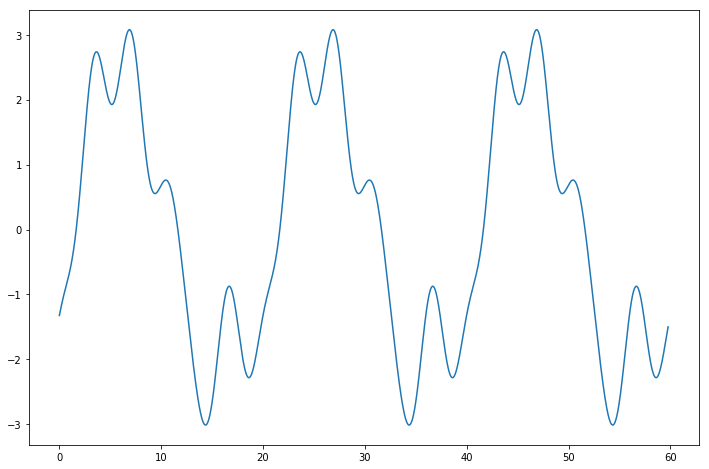

In [106]:
from matplotlib import pyplot as plt
plt.close()

# for d in range(rbt.dof):
#     co_num = str(d + 1)
#     plt.plot(t_raw, q_raw[:, d], label=(r"$q_" + co_num +"$"), linestyle= (0, ()))
    
for i in range(q_raw.shape[1]):
    plt.plot(t_raw,q_raw[:,i])

plt.show()

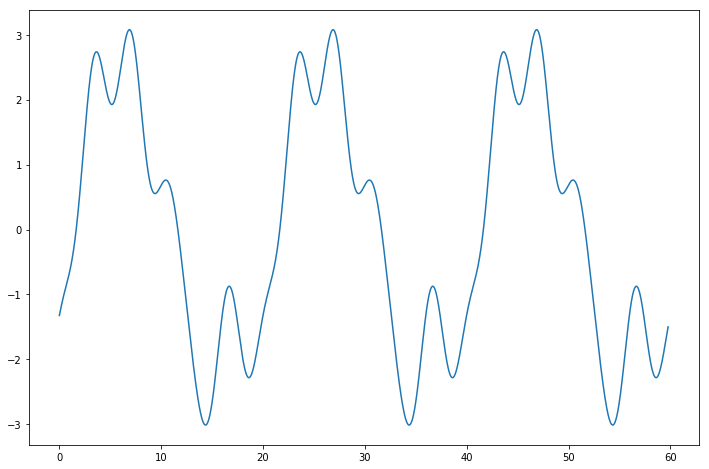

In [107]:
from matplotlib import pyplot as plt
plt.close()

joint = 1
# plt.plot(t_ref+0.20,q_ref[:,joint-1])
plt.plot(t_raw,q_raw[:,joint-1])

plt.show()

In [108]:
del t_raw, q_raw, dq_raw,tau_raw

### Parameter Load

In [110]:
from utils import save_data, load_data

training_trajectory_name = 'onedof_traj1'


trajectory_folder = datafolder +'trajectories/'
dof, fourier_order, base_freq, traj_optimizer_result, reg_norm_mat = load_data(trajectory_folder,
                                                                               training_trajectory_name)
print("dof: {}".format(dof))
print("Fourier order: {}".format(fourier_order))
print("Base frequency: {}".format(base_freq))

dof: 1
Fourier order: 6
Base frequency: 0.05


### Filter Cut-off Frequency Definition

In [111]:
# times of the highest frequency in the Fourier series
fc_mult = 10.0

fc = base_freq * fourier_order * fc_mult
print("Cut frequency: {}".format(fc))

Cut frequency: 3.0


In [112]:
fc_q = fc
fc_dq = fc
fc_ddq = fc

fc_tau =  fc

si = 200
sf = -200

### Data Filtering, Differentiation and Regression Data Generation

In [113]:
rec_h = 0.02

In [114]:
from support_funcs.regr_data_proc import load_trajectory_data, plot_trajectory_data, \
                                            diff_and_filt_data, gen_regr_matrices


def process_regression_data(traj_name):
#     t_raw, q_raw, tau_raw, t_ref, q_ref = read_data(dof=rbt.dof, h=rec_h,
#                                                     rbtlogfile=datafolder + 'recdata/rbtlog_%s.dat'%traj_name,
#                                                     trajreffile=datafolder + 'trajectories/%s.dat'%traj_name)
    
    training_results_data_file = datafolder +'recdata/' + 'onedof_%s_results.csv'%traj_name
    trajectory_sampling_rate = 50
    t_raw, q_raw, dq_raw, tau_raw = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)
    
    q, dq, ddq, tau = diff_and_filt_data(dof=rbt.dof, h=rec_h,  q_raw=q_raw, tau_raw=tau_raw,
                                   fc_q=fc_q, fc_dq=fc_dq, fc_ddq=fc_ddq, fc_tau=fc_tau)
    
    t_raw = t_raw[si:sf]; q_raw = q_raw[si:sf]; tau_raw = tau_raw[si:sf]
    q = q[si:sf]; dq = dq[si:sf]; ddq = ddq[si:sf]; tau = tau[si:sf]
    
    t_raw = t_raw - t_raw[0]
    
    t = numpy.array(range(q.shape[0])) * rec_h
    
    W, omega, Q1, R1, rho1 = gen_regr_matrices(rbt, q, dq, ddq, tau)
    
    return t_raw, q_raw, tau_raw, t, q, dq, ddq, tau, W, omega, Q1, R1, rho1

>>>>>>>> traj4 proc <<<<<<<<<
(<type 'numpy.ndarray'>, (2990, 3))
CPU times: user 76.8 ms, sys: 4.02 ms, total: 80.8 ms
Wall time: 78.9 ms
 (cond=5.943057)
traj4 save
CPU times: user 56.7 ms, sys: 4.37 ms, total: 61 ms
Wall time: 17.9 ms
plot shape: 410


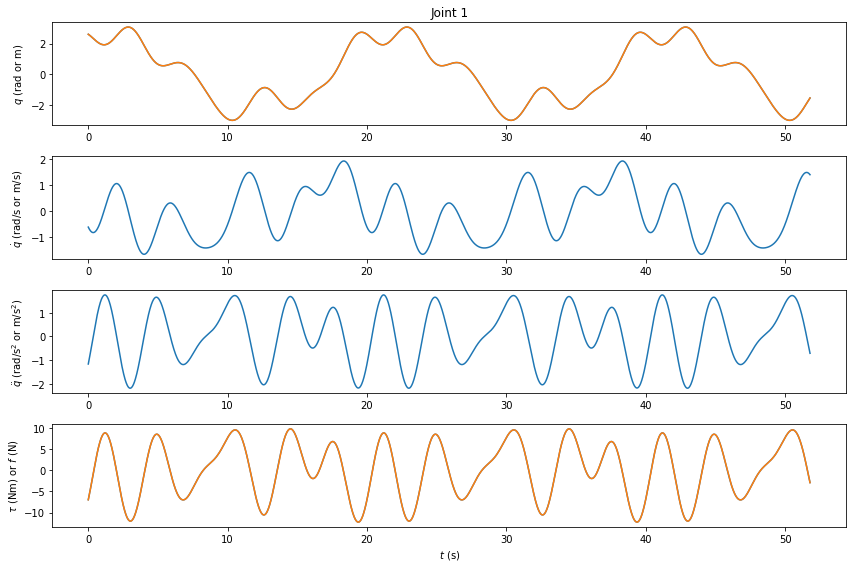

In [286]:
from support_funcs.utils import _fprint
from support_funcs.regr_data_proc import plot_trajectory_data

for traj in ['traj4']:      #, 'traj2', 'traj3', 'traj4'
    _fprint('>>>>>>>> %s proc <<<<<<<<<'%traj)
    %time t_raw, q_raw, tau_raw, t, q, dq, ddq, tau, W, omega, Q1, R1, rho1 = process_regression_data(traj)
    
    _fprint(' (cond=%f)'%numpy.linalg.cond(W))
    
    _fprint('%s save'%traj)
    
    %time \
    numpy.savez_compressed(tmpfolder + 'procdata/' + traj + '_raw', t=t_raw, q=q_raw, tau=tau_raw);\
    numpy.savez_compressed(tmpfolder + 'procdata/' + traj + '_proc', t=t, q=q, dq=dq, ddq=ddq, tau=tau); \
    numpy.savez_compressed(tmpfolder + 'procdata/' + traj + '_regr', W=W, omega=omega, Q1=Q1, R1=R1, rho1=rho1)
    
    import matplotlib.pyplot as plt
    plt.rcParams['figure.figsize'] = [12,8]
    plot_trajectory_data(t, q_raw, q, dq, ddq,
                     tau_raw, tau)
    
    del t_raw, q_raw, tau_raw, t, q, dq, ddq, tau, W, omega, Q1, R1, rho1

### Plot

In [116]:
raw = numpy.load(tmpfolder + 'procdata/traj1_raw.npz')
tau_raw = raw['tau']
q_raw = raw['q']
del raw
proc = numpy.load(tmpfolder + 'procdata/traj1_proc.npz')
t = proc['t']
tau = proc['tau']
q = proc['q']
dq = proc['dq']
del proc

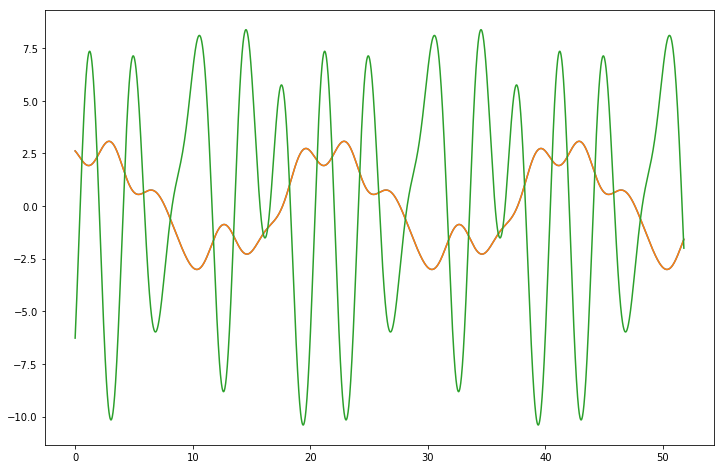

In [117]:
from matplotlib import pyplot as plt
plt.close()

joint = 1
firsts = 20000
plt.plot(t[:firsts],q_raw[:,joint-1][:firsts])
plt.plot(t[:firsts],q[:,joint-1][:firsts])
#plt.plot(t[:firsts],dq[:,joint-1][:firsts])
plt.plot(t[:firsts],tau_raw[:,joint-1][:firsts])

plt.show()

In [118]:
del t, q, dq, tau, q_raw, tau_raw

4 - Dynamic Parameter Estimation
================================

In [119]:
import os
import pickle
import sympy
import numpy
import time

import sympybotics
import lmi_sdp

from lmi_sdp import init_lmi_latex_printing
init_lmi_latex_printing()

In [120]:
with open(tmpfolder +  'robotmodels/onedof_model.pkl', 'rb' ) as file:
          rbt = pickle.load( file )

In [121]:
epsilon_safemargin = 1e-6
epsilon_sdptol = 1e-7

## LMI Matrix Definitions

In [122]:
dof = rbt.dof

delta = rbt.dyn.dynparms
n_delta = rbt.dyn.n_dynparms

beta = rbt.dyn.baseparms.n()
n_beta = rbt.dyn.n_base
beta_symbs = sympy.Matrix([sympy.Symbol('beta'+str(i+1),real=True) for i in range(n_beta)])

delta_d = (rbt.dyn.Pd.T*delta)
n_delta_d = len(delta_d)

Pb = rbt.dyn.Pb

varchange_dict = dict(zip(Pb.T*delta ,  beta_symbs - ( beta - Pb.T*delta )))

In [123]:
from support_funcs.utils import skew, mrepl
from sympy import BlockMatrix, Matrix, eye, Identity
I = Identity
S = skew

In [124]:
D_inertia_blocks = []
for i in range(dof):
    L = rbt.rbtdef.L[i]
    l = rbt.rbtdef.l[i]
    m = rbt.rbtdef.m[i]
    Di = BlockMatrix([[L,    S(l).T],
                      [S(l), I(3)*m]])
    D_inertia_blocks.append(Di.as_explicit())

In [125]:
D_inertia_blocks[0]

Matrix([
[L_1xx, L_1xy, L_1xz,     0,  l_1z, -l_1y],
[L_1xy, L_1yy, L_1yz, -l_1z,     0,  l_1x],
[L_1xz, L_1yz, L_1zz,  l_1y, -l_1x,     0],
[    0, -l_1z,  l_1y,   m_1,     0,     0],
[ l_1z,     0, -l_1x,     0,   m_1,     0],
[-l_1y,  l_1x,     0,     0,     0,   m_1]])

In [126]:
D_other_blocks = []
for i in range(dof):
    if rbt.rbtdef.driveinertiamodel == 'simplified':
        D_other_blocks.append( Matrix([rbt.rbtdef.Ia[i]]) )
    if 'viscous' in rbt.rbtdef.frictionmodel:
        D_other_blocks.append( Matrix([rbt.rbtdef.fv[i]]) )
    if 'Coulomb' in rbt.rbtdef.frictionmodel:
        D_other_blocks.append( Matrix([rbt.rbtdef.fc[i]]) )

D_other_blocks

[]

In [127]:
D_blocks = D_inertia_blocks + D_other_blocks

In [128]:
D_blocks

[Matrix([
 [L_1xx, L_1xy, L_1xz,     0,  l_1z, -l_1y],
 [L_1xy, L_1yy, L_1yz, -l_1z,     0,  l_1x],
 [L_1xz, L_1yz, L_1zz,  l_1y, -l_1x,     0],
 [    0, -l_1z,  l_1y,   m_1,     0,     0],
 [ l_1z,     0, -l_1x,     0,   m_1,     0],
 [-l_1y,  l_1x,     0,     0,     0,   m_1]])]

## Change of Variable Space

In [129]:
varchange_dict = dict(zip(Pb.T*delta ,  beta_symbs - ( beta - Pb.T*delta )))

In [130]:
DB_blocks = [mrepl(Di, varchange_dict) for Di in D_blocks]
DB_blocks

[Matrix([
 [ L_1xx, L_1xy,  L_1xz,     0,   l_1z, -beta3],
 [ L_1xy, L_1yy,  L_1yz, -l_1z,      0,  beta2],
 [ L_1xz, L_1yz,  beta1, beta3, -beta2,      0],
 [     0, -l_1z,  beta3,   m_1,      0,      0],
 [  l_1z,     0, -beta2,     0,    m_1,      0],
 [-beta3, beta2,      0,     0,      0,    m_1]])]

## LMI Definitions

In [131]:
from lmi_sdp import LMI_PD, LMI

In [132]:
DB_LMIs = list(map(LMI_PD, DB_blocks))

In [133]:
DB_LMIs[0]

Matrix([
[ L_1xx, L_1xy,  L_1xz,     0,   l_1z, -beta3],
[ L_1xy, L_1yy,  L_1yz, -l_1z,      0,  beta2],
[ L_1xz, L_1yz,  beta1, beta3, -beta2,      0],
[     0, -l_1z,  beta3,   m_1,      0,      0],
[  l_1z,     0, -beta2,     0,    m_1,      0],
[-beta3, beta2,      0,     0,      0,    m_1]]) > 0

In [134]:
DB_LMIs_marg = list(map(lambda lm: LMI(lm, epsilon_safemargin*eye(lm.shape[0])) , DB_blocks))

In [135]:
DB_LMIs_marg[0]

Matrix([
[ L_1xx, L_1xy,  L_1xz,     0,   l_1z, -beta3],
[ L_1xy, L_1yy,  L_1yz, -l_1z,      0,  beta2],
[ L_1xz, L_1yz,  beta1, beta3, -beta2,      0],
[     0, -l_1z,  beta3,   m_1,      0,      0],
[  l_1z,     0, -beta2,     0,    m_1,      0],
[-beta3, beta2,      0,     0,      0,    m_1]]) >= Matrix([
[1.0e-6,      0,      0,      0,      0,      0],
[     0, 1.0e-6,      0,      0,      0,      0],
[     0,      0, 1.0e-6,      0,      0,      0],
[     0,      0,      0, 1.0e-6,      0,      0],
[     0,      0,      0,      0, 1.0e-6,      0],
[     0,      0,      0,      0,      0, 1.0e-6]])

In [136]:
DB_LMIs_marg[0].canonical()

Matrix([
[L_1xx - 1.0e-6,          L_1xy,          L_1xz,            0,         l_1z,       -beta3],
[         L_1xy, L_1yy - 1.0e-6,          L_1yz,        -l_1z,            0,        beta2],
[         L_1xz,          L_1yz, beta1 - 1.0e-6,        beta3,       -beta2,            0],
[             0,          -l_1z,          beta3, m_1 - 1.0e-6,            0,            0],
[          l_1z,              0,         -beta2,            0, m_1 - 1.0e-6,            0],
[        -beta3,          beta2,              0,            0,            0, m_1 - 1.0e-6]]) >= 0

## SDP Solver Interfaces

### [SDPA](http://sdpa.sourceforge.net/)

In [137]:
def sdpa(objf, lmis, variables):
    sdpadat = lmi_sdp.to_sdpa_sparse(objf, lmis, variables)
    with open(tmpfolder + 'sdpa_dat/sdp.dat-s', 'w') as f:
        f.write(sdpadat)
    
    stdout = !sdpa -ds "$tmpfolder"sdpa_dat/sdp.dat-s -o "$tmpfolder"sdpa_dat/sdpa.out -p "$tmpfolder"sdpa_dat/param.sdpa -pt 2
    print('\n'.join(stdout))

    outfile = !cat "$tmpfolder"sdpa_dat/sdpa.out
    sol = [float(v) for v in outfile[outfile.index('xVec = ') + 1].replace('{', '').replace('}', '').split(',')]
    return numpy.matrix(sol).T

### [CSDP](https://projects.coin-or.org/Csdp/)

In [103]:
def csdp(objf, lmis, variables):
    sdpadat = lmi_sdp.to_sdpa_sparse(objf, lmis, variables)
    with open(tmpfolder + 'sdpa_dat/sdp.dat-s', 'w') as f:
        f.write(sdpadat)
    
    stdout = !cd "$tmpfolder"sdpa_dat; csdp sdp.dat-s csdp.out
    print('\n'.join(stdout))

    outfile = !cat "$tmpfolder"sdpa_dat/csdp.out
    sol = [float(v) for v in outfile[0].split()]
    return numpy.matrix(sol).T

### [DSDP5](doi.org/10.1145/1356052.1356057)

In [138]:
def dsdp5(objf, lmis, variables):
    sdpadat = lmi_sdp.to_sdpa_sparse(objf, lmis, variables)
    with open(tmpfolder + 'sdpa_dat/sdp.dat-s', 'w') as f:
        f.write(sdpadat)
    
    stdout = !cd "$tmpfolder"sdpa_dat; dsdp5 sdp.dat-s -save dsdp5.out -gaptol $epsilon_sdptol
    print('\n'.join(stdout))

    outfile = !cat "$tmpfolder"sdpa_dat/dsdp5.out
    sol = [float(v) for v in outfile[0].split()]
    return numpy.matrix(sol).T

### [DSDP5 through CVXOPT](http://abel.ee.ucla.edu/cvxopt/userguide/coneprog.html#cvxopt.solvers.sdp)

In [142]:
def cvxopt_dsdp5(objf, lmis, variables):
    import cvxopt.solvers
    c, Gs, hs = lmi_sdp.to_cvxopt(objf, lmis, variables)
    cvxopt.solvers.options['DSDP_GapTolerance'] = epsilon_sdptol
    tic = time.time()
    sdpout = cvxopt.solvers.sdp(c, Gs=Gs, hs=hs, solver='dsdp')
    toc = time.time()
    print(sdpout['status'], ('ATT!: \'optimal\' does not necessarlly means feasible'))
    print('Elapsed time: %.2f s'%(toc-tic))
    return numpy.matrix(sdpout['x'])

### [CVXOPT CONELP](http://abel.ee.ucla.edu/cvxopt/userguide/coneprog.html#cvxopt.solvers.sdp)

In [143]:
def cvxopt_conelp(objf, lmis, variables):
    import cvxopt.solvers
    c, Gs, hs = lmi_sdp.to_cvxopt(objf, lmis, variables)
    cvxopt.solvers.options['feastol'] = epsilon_sdptol
    tic = time.time()
    sdpout = cvxopt.solvers.sdp(c, Gs=Gs, hs=hs)
    toc = time.time()
    print(sdpout['status'])
    print('Elapsed time: %.2f s'%(toc-tic))
    return numpy.matrix(sdpout['x'])

### [Raw SDPA file](http://plato.asu.edu/ftp/sdpa_format.txt)

Can be solved online with a *Semidefinite Programming* solver at [NEOS Solvers](http://www.neos-server.org/neos/solvers/index.html)

In [139]:
def sdpa_file(objf, lmis, variables):
    sdpadat = lmi_sdp.to_sdpa_sparse(objf, lmis, variables)
    with open(tmpfolder + 'sdpa_dat/sdpa_input.dat-s', 'w') as f:
        f.write(sdpadat)
        
    print("SDPA file saved at: %ssdpa_dat/sdpa_input.dat-s"%tmpfolder)

--------------

Setting the default SDP solver:

In [140]:
solve_sdp = dsdp5

## OLS Regression ($\hat{\beta}$)

In [289]:
indentification_traj = 'traj4'

In [290]:
regr_mats = numpy.load(tmpfolder + 'procdata/' + indentification_traj + '_regr.npz')
W = numpy.matrix(regr_mats['W'])
omega = numpy.matrix(regr_mats['omega'])
R1 = numpy.matrix(regr_mats['R1'])
rho1 = numpy.matrix(regr_mats['rho1'])

In [291]:
omega.shape[0] / rbt.dof

2590

In [292]:
W.shape

(2590, 3)

In [293]:
numpy.linalg.cond(W)

5.943056535936258

In [294]:
%time beta_ols = (R1.T * R1).I * R1.T * rho1

CPU times: user 382 µs, sys: 31 µs, total: 413 µs
Wall time: 329 µs


In [295]:
numpy.savetxt(tmpfolder + 'solutions/' + indentification_traj + '_beta_ols.dat', beta_ols)

In [296]:
rho2_norm_sqr = numpy.linalg.norm(omega - W * beta_ols)**2

### plot measured and predicted torque

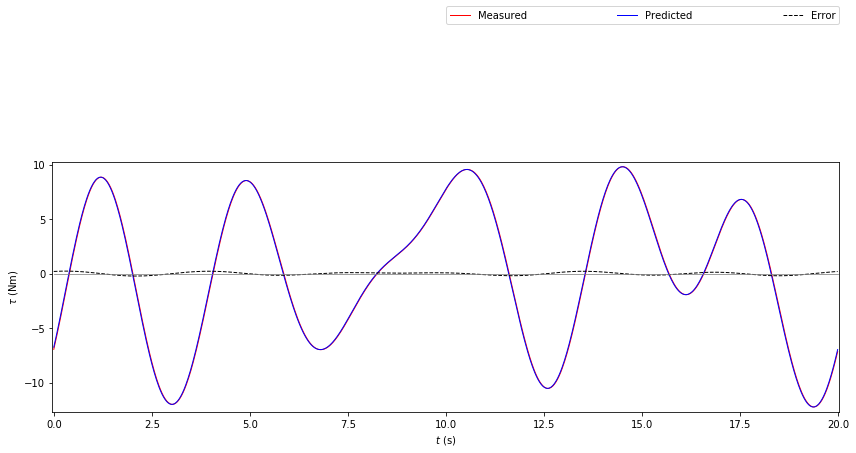

In [297]:
from support_funcs.regr_data_proc import  plot_meas_pred_tau

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,8]

proc = numpy.load(tmpfolder + 'procdata/' + indentification_traj + '_proc.npz')
t = proc['t']
tau = proc['tau']

tau_p = np.zeros(tau.shape)
tau_ps = W.dot(beta_ols)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof].flatten()

base_freq = 0.05    
trajectory_sampling_rate = 50
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t[:plot_data_num], tau[:plot_data_num, :],
                   tau_p[:plot_data_num, :])

## Weighted Least Square (WLS)

In [298]:
proc = numpy.load(tmpfolder + 'procdata/' + indentification_traj + '_proc.npz')
t = proc['t']
tau = proc['tau']

weight = np.max(tau, axis=0) - np.min(tau, axis=0)
print("weight: ")
print(weight)


# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W.shape[0]/weight.shape[0])

weight: 
[22.04931097]


In [299]:
weights[0:6]

array([0.04535289, 0.04535289, 0.04535289, 0.04535289, 0.04535289,
       0.04535289])

In [300]:
W_wls = np.multiply(W, np.asmatrix(weights).transpose())
omega_wls = np.multiply(omega.T, weights).T
Q1_wls,R1_wls = numpy.linalg.qr(W_wls)
rho1_wls = Q1_wls.T*omega_wls

In [301]:
%time beta_wls = (R1_wls.T * R1_wls).I * R1_wls.T * rho1_wls

CPU times: user 1.14 ms, sys: 89 µs, total: 1.22 ms
Wall time: 752 µs


In [302]:
numpy.savetxt(tmpfolder + 'solutions/' + indentification_traj + '_beta_wls.dat', beta_wls)

In [303]:
rho2_norm_sqr_wls = numpy.linalg.norm(omega_wls - W_wls * beta_wls)**2

### plot measured and predicted torque

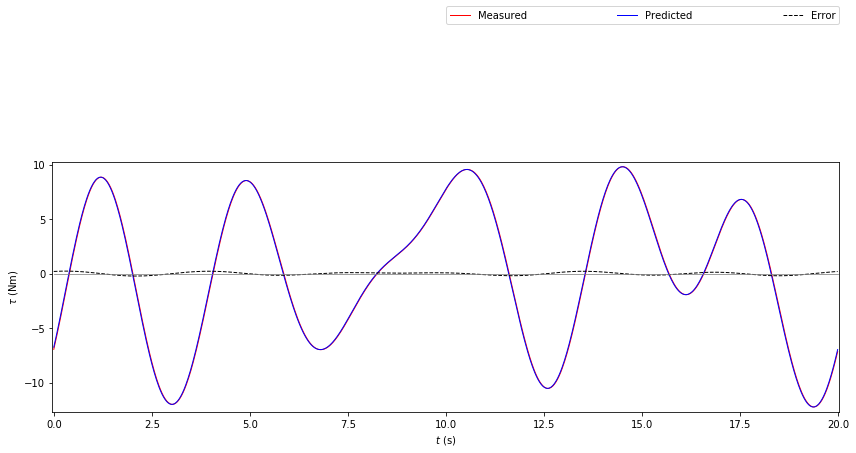

In [304]:
from support_funcs.regr_data_proc import  plot_meas_pred_tau

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,8]

proc = numpy.load(tmpfolder + 'procdata/' + indentification_traj + '_proc.npz')
t = proc['t']
tau = proc['tau']

tau_p = np.zeros(tau.shape)
tau_ps = W.dot(beta_wls)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof].flatten()

base_freq = 0.05    
trajectory_sampling_rate = 50
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t[:plot_data_num], tau[:plot_data_num, :],
                   tau_p[:plot_data_num, :])

### Base Parameter Feasibility Test (BPFT) of OLS Solution

In [305]:
dict_subs = dict(zip(beta_symbs, beta_wls.flatten().tolist()[0]))
lmis_ols_bpft = [ lmi_sdp.LMI_PD(mrepl(lmi.canonical().gts, dict_subs)) for lmi in DB_LMIs ]

In [306]:
lmis_ols_bpft[0]

Matrix([
[             L_1xx,                 L_1xy,                L_1xz,                   0,                 l_1z,    0.0798258216521998],
[             L_1xy,                 L_1yy,                L_1yz,               -l_1z,                    0, -0.000475646572722181],
[             L_1xz,                 L_1yz,     5.46444082207529, -0.0798258216521998, 0.000475646572722181,                     0],
[                 0,                 -l_1z,  -0.0798258216521998,                 m_1,                    0,                     0],
[              l_1z,                     0, 0.000475646572722181,                   0,                  m_1,                     0],
[0.0798258216521998, -0.000475646572722181,                    0,                   0,                    0,                   m_1]]) > 0

In [307]:
variables_ols_bpft = list(delta_d)
objf_ols_bpft = 0  # no objective function - "find" problem

Testing with all solvers

**Just one of the following calls is sufficient to show feasibility/infeasibility**

In [308]:
sol = sdpa_file(objf_ols_bpft, lmis_ols_bpft, variables_ols_bpft) # One can solve the output file at http://www.neos-server.org/neos/solvers/sdp:DSDP/SDPA.html for example.

SDPA file saved at: tmp/sdpa_dat/sdpa_input.dat-s


In [309]:
sol = dsdp5(objf_ols_bpft, lmis_ols_bpft, variables_ols_bpft)

sdp.dat-s -save dsdp5.out -gaptol 1e-07 

Variables 7 
Matrix Blocks: 1, Total Number of Constraints: 6 
Nonzeros in Constraints: 15

Read Data File into Buffer:      6.080e-05 seconds
DSDP Set Data:                   6.700e-05 seconds
DSDP Process Data:               6.008e-05 seconds

Data Norms: C: 5.47e+00, A: 3.87e+00, b: 0.00e+00
Scale C: 7.08e-01

Potential Parameter: 5.00
Reapply Schur matrix: 4

Iter   PP Objective      DD Objective    PInfeas   DInfeas     Nu     StepLength   Pnrm
---------------------------------------------------------------------------------------
0     1.00000000e+10   -4.36543761e+09   1.0e+00   4.4e+01   4.4e+09  0.00  0.00   0.00 
10    2.04138633e+05    0.00000000e+00   6.5e-04   0.0e+00   9.1e+02  1.00  1.00   0.59 
18    4.06053146e-08    0.00000000e+00   7.9e-16   0.0e+00   3.3e-11  1.00  1.00   0.00 
DSDP Converged. 

P Objective  :   2.03573017e-09 
DSDP Solution:   0.00000000e+00 

DSDP Solve Time:                     1.293e-03 seconds
DSDP Prep

In [162]:
sol = sdpa(objf_ols_bpft, lmis_ols_bpft, variables_ols_bpft)

SDPA (Version 7.3.9) start at [Tue Oct 30 15:39:15 2018]
set   is STABLE_BUT_SLOW
data  is tmp/sdpa_dat/sdp.dat-s : sparse
out   is tmp/sdpa_dat/sdpa.out
NumThreads  is set as 1
Schur computation : DENSE 
Entering DMUMPS driver with JOB, N, NZ =  -2           0              0
   mu      thetaP  thetaD  objP      objD      alphaP  alphaD  beta 
 0 1.0e+08 1.0e+00 1.0e+00 -0.00e+00 -4.63e+04 8.0e-01 8.0e-01 3.00e-01
 1 3.0e+07 2.0e-01 2.0e-01 -0.00e+00 -6.85e+04 8.0e-01 8.0e-01 3.00e-01
 2 8.8e+06 4.0e-02 4.0e-02 -0.00e+00 -1.01e+05 8.1e-01 8.0e-01 3.00e-01
 3 2.6e+06 7.5e-03 8.0e-03 -0.00e+00 -1.48e+05 8.5e-01 8.0e-01 3.00e-01
 4 7.7e+05 1.1e-03 1.6e-03 -0.00e+00 -2.04e+05 1.0e+00 8.0e-01 3.00e-01
 5 2.4e+05 8.9e-20 3.2e-04 -0.00e+00 -2.15e+05 8.0e+01 8.0e-01 3.00e-01
 6 2.0e+06 8.9e-20 6.4e-05 -0.00e+00 -1.02e+05 8.0e+01 8.0e-01 3.00e-01
 7 1.7e+07 8.9e-20 1.3e-05 -0.00e+00 -5.03e+05 8.0e+01 8.0e-01 3.00e-01
 8 1.4e+08 8.9e-20 2.6e-06 -0.00e+00 -4.08e+06 8.0e+01 8.0e-01 3.00e-01
 9 1.1

In [135]:
sol = csdp(objf_ols_bpft, lmis_ols_bpft, variables_ols_bpft)

This is a pure dual feasibility problem.
Iter:  0 Ap: 0.00e+00 Pobj: -3.8296290e+03 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 8.96e-01 Pobj: -5.2770492e+03 Ad: 8.16e-01 Dobj:  0.0000000e+00 
Iter:  2 Ap: 6.30e-01 Pobj: -4.7758728e+03 Ad: 6.04e-01 Dobj:  0.0000000e+00 
Iter:  3 Ap: 5.03e-01 Pobj: -4.1867025e+03 Ad: 8.53e-01 Dobj:  0.0000000e+00 
Iter:  4 Ap: 8.74e-01 Pobj: -1.5539887e+03 Ad: 4.75e-01 Dobj:  0.0000000e+00 
Iter:  5 Ap: 3.90e-01 Pobj:  2.5868012e+00 Ad: 2.09e-01 Dobj:  0.0000000e+00 
Iter:  6 Ap: 8.83e-02 Pobj:  2.6946911e+03 Ad: 1.83e-01 Dobj:  0.0000000e+00 
Iter:  7 Ap: 3.62e-03 Pobj:  8.0058280e+03 Ad: 1.06e-02 Dobj:  0.0000000e+00 
Iter:  8 Ap: 1.61e-02 Pobj:  6.0199514e+04 Ad: 1.30e-02 Dobj:  0.0000000e+00 
Iter:  9 Ap: 6.67e-03 Pobj:  2.9195543e+05 Ad: 8.91e-03 Dobj:  0.0000000e+00 
Iter: 10 Ap: 4.86e-03 Pobj:  1.5474164e+06 Ad: 7.36e-03 Dobj:  0.0000000e+00 
Iter: 11 Ap: 7.92e-04 Pobj:  3.2963353e+06 Ad: 1.12e-02 Dobj:  0.0000000e+00 
Iter: 12 Ap: 1.26e-03 P

In [144]:
sol = cvxopt_conelp(objf_ols_bpft, lmis_ols_bpft, variables_ols_bpft)

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.2158e+01  1e+02  2e+00  7e+00  1e+00
 1:  0.0000e+00 -2.3016e-01  3e+00  2e-01  6e-01  8e-01
 2:  0.0000e+00 -9.6107e-02  1e+00  6e-02  2e-01  3e-01
 3:  0.0000e+00  2.0962e-01  4e+01  3e-01  1e+00  2e+00
 4:  0.0000e+00  7.3312e-01  3e+01  1e-01  5e-01  2e+00
 5:  0.0000e+00  4.7892e-01  2e+01  7e-02  3e-01  1e+00
 6:  0.0000e+00  3.4714e+00  1e+02  6e-02  2e-01  4e+00
 7:  0.0000e+00  1.1664e+01  3e+02  6e-02  2e-01  1e+01
 8:  0.0000e+00  1.0313e+02  2e+03  5e-02  2e-01  1e+02
 9:  0.0000e+00  1.7208e+03  4e+04  5e-02  2e-01  2e+03
10:  0.0000e+00  1.3030e+04  3e+05  5e-02  2e-01  1e+04
11:  0.0000e+00  9.8979e+04  2e+06  5e-02  2e-01  1e+05
12:  0.0000e+00  3.6891e+05  8e+06  5e-02  2e-01  4e+05
13:  0.0000e+00  9.4734e+05  2e+07  5e-02  2e-01  9e+05
14:  0.0000e+00  1.0511e+06  3e+07  5e-02  2e-01  1e+06
15:  0.0000e+00  1.0467e+07  3e+08  5e-02  2e-01  1e+07
Certificate of primal infeasibility found.
primal 

## Base Parameter Feasibility Correction (BPFC)     ($\beta^\prime$)

In [310]:
u = sympy.Symbol('u')
U_beta = BlockMatrix([[Matrix([u]),            (beta_wls - beta_symbs).T],
                 [beta_wls - beta_symbs,                 I(n_beta)]])
U_beta = U_beta.as_explicit()

In [311]:
lmis_ols_bpfc = [LMI(U_beta)] + DB_LMIs_marg

In [312]:
lmis_ols_bpfc[1]

Matrix([
[ L_1xx, L_1xy,  L_1xz,     0,   l_1z, -beta3],
[ L_1xy, L_1yy,  L_1yz, -l_1z,      0,  beta2],
[ L_1xz, L_1yz,  beta1, beta3, -beta2,      0],
[     0, -l_1z,  beta3,   m_1,      0,      0],
[  l_1z,     0, -beta2,     0,    m_1,      0],
[-beta3, beta2,      0,     0,      0,    m_1]]) >= Matrix([
[1.0e-6,      0,      0,      0,      0,      0],
[     0, 1.0e-6,      0,      0,      0,      0],
[     0,      0, 1.0e-6,      0,      0,      0],
[     0,      0,      0, 1.0e-6,      0,      0],
[     0,      0,      0,      0, 1.0e-6,      0],
[     0,      0,      0,      0,      0, 1.0e-6]])

In [313]:
variables_ols_bpfc = [u] + list(beta_symbs) + list(delta_d)

In [314]:
objf_ols_bpfc = u

In [315]:
sol_ols_bpfc = solve_sdp(objf_ols_bpfc, lmis_ols_bpfc, variables_ols_bpfc)

sdp.dat-s -save dsdp5.out -gaptol 1e-07 

Variables 11 
Matrix Blocks: 2, Total Number of Constraints: 10 
Nonzeros in Constraints: 31

Read Data File into Buffer:      1.030e-04 seconds
DSDP Set Data:                   8.702e-05 seconds
DSDP Process Data:               8.106e-05 seconds

Data Norms: C: 7.92e+00, A: 5.57e+00, b: 1.00e+00
Scale C: 7.14e-01

Potential Parameter: 5.00
Reapply Schur matrix: 4

Iter   PP Objective      DD Objective    PInfeas   DInfeas     Nu     StepLength   Pnrm
---------------------------------------------------------------------------------------
0     1.00000000e+10   -5.02270726e+11   2.0e+00   5.0e+03   5.0e+11  0.00  0.00   0.00 
10    1.17043500e+12   -1.10685145e+10   1.6e+04   1.1e+02   1.5e+09  1.00  1.00  13.34 
20    7.55322115e+04   -5.27518490e+02   9.7e-04   0.0e+00   2.6e+02  1.00  1.00   1.70 
30    2.06151125e-07   -4.06059485e-10   2.6e-15   0.0e+00   1.3e-09  1.00  0.19   5.06 
31    4.15147677e-08   -1.82744606e-10   5.2e-16   0.0e+00

In [316]:
u_prime = sol_ols_bpfc[0,0]
beta_prime = sol_ols_bpfc[1:1+n_beta]
delta_d_prime = sol_ols_bpfc[1+n_beta:]

In [317]:
u_prime

4.0605948508991616e-10

### plot measured and predicted torque

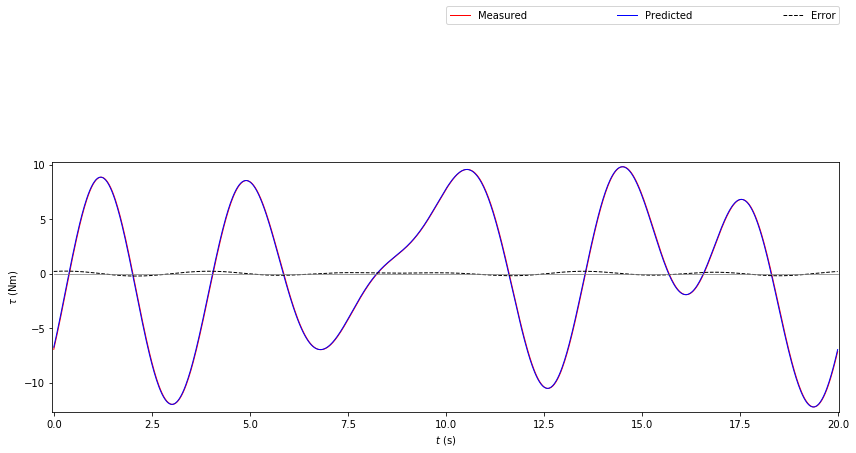

In [318]:
# from support_funcs.regr_data_proc import  plot_meas_pred_tau

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,8]

proc = numpy.load(tmpfolder + 'procdata/' + indentification_traj + '_proc.npz')
t = proc['t']
tau = proc['tau']

tau_p = np.zeros(tau.shape)
tau_ps = W.dot(beta_prime)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof].flatten()

base_freq = 0.05    
trajectory_sampling_rate = 50
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t[:plot_data_num], tau[:plot_data_num, :],
                   tau_p[:plot_data_num, :])

### Solution Double Check

In [319]:
dict_subs = dict(zip(beta_symbs, beta_prime.flatten().tolist()[0]))
dict_subs.update(dict(zip(delta_d, delta_d_prime.flatten().tolist()[0])))

test = 'ok'
for i, DBi in enumerate(DB_blocks):
        m = numpy.matrix(mrepl(DBi, dict_subs)).astype(float)
        for v in numpy.linalg.eigvals( m ):
            if v <= 0.0:
                print i, v
                test = 'fail'
print(test)

ok


In [320]:
numpy.savetxt(tmpfolder + 'solutions/' + indentification_traj + '_beta_prime.dat', beta_prime)

## Feasible Base Parameter Estimation with Weight Least Squares (FBPE-WLS)     ($\beta^\star$)

In [321]:
u = sympy.Symbol('u')
U_rho = BlockMatrix([[Matrix([u - rho2_norm_sqr_wls]), (rho1_wls - R1_wls*beta_symbs).T],
                     [rho1_wls - R1_wls*beta_symbs,                       I(n_beta)]])
U_rho = U_rho.as_explicit()

In [322]:
lmis_fbpe_ols = [LMI(U_rho)] + DB_LMIs_marg

In [323]:
variables_fbpe_ols = [u] + list(beta_symbs) + list(delta_d)

In [324]:
objf_fbpe_ols = u

In [325]:
sol_fbpe_ols = solve_sdp(objf_fbpe_ols, lmis_fbpe_ols, variables_fbpe_ols)

sdp.dat-s -save dsdp5.out -gaptol 1e-07 

Variables 11 
Matrix Blocks: 2, Total Number of Constraints: 10 
Nonzeros in Constraints: 35

Read Data File into Buffer:      9.012e-05 seconds
DSDP Set Data:                   7.296e-05 seconds
DSDP Process Data:               2.680e-04 seconds

Data Norms: C: 2.11e+01, A: 3.26e+01, b: 1.00e+00
Scale C: 1.00e+00

Potential Parameter: 5.00
Reapply Schur matrix: 4

Iter   PP Objective      DD Objective    PInfeas   DInfeas     Nu     StepLength   Pnrm
---------------------------------------------------------------------------------------
0     1.00000000e+10   -2.23948414e+11   2.0e+00   2.2e+03   2.2e+11  0.00  0.00   0.00 
10    2.04115001e+11   -1.21302519e+10   2.9e+03   1.2e+02   2.4e+09  1.00  1.00   1.03 
20    6.63400199e+03   -1.77535389e+01   8.4e-05   0.0e+00   8.9e+00  1.00  1.00   7.75 
28   -8.52549163e-02   -8.52549608e-02   5.6e-16   0.0e+00   2.9e-10  1.00  0.19   5.07 
DSDP Converged. 

P Objective  :  -8.52549550e-02 
DSDP So

In [326]:
u_star = sol_fbpe_ols[0,0]
beta_star = numpy.matrix(sol_fbpe_ols[1:1+n_beta])
delta_d_star = numpy.matrix(sol_fbpe_ols[1+n_beta:])

In [327]:
u_star

0.08525496248290194

### plot measured and predicted torque

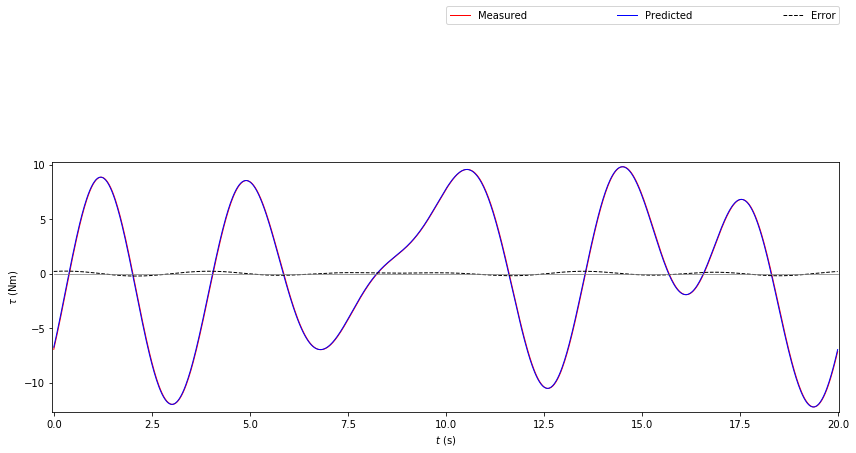

In [328]:
# from support_funcs.regr_data_proc import  plot_meas_pred_tau

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,8]

proc = numpy.load(tmpfolder + 'procdata/' + indentification_traj + '_proc.npz')
t = proc['t']
tau = proc['tau']

tau_p = np.zeros(tau.shape)
tau_ps = W.dot(beta_star)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof].flatten()

base_freq = 0.05    
trajectory_sampling_rate = 50
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t[:plot_data_num], tau[:plot_data_num, :],
                   tau_p[:plot_data_num, :])

### Solution Double Check

In [329]:
dict_subs = dict(zip(beta_symbs, beta_star.flatten().tolist()[0]))
dict_subs.update(dict(zip(delta_d, delta_d_star.flatten().tolist()[0])))

test = 'ok'
for DBi in DB_blocks:
        m = numpy.matrix(mrepl(DBi, dict_subs)).astype(float)
        for v in numpy.linalg.eigvals( m ):
            if v <= 0.0:
                print(v)
                test = 'fail'
print(test)

ok


In [330]:
numpy.savetxt(tmpfolder + 'solutions/' + indentification_traj + '_beta_star.dat', beta_star)

## Additional Constraints on Centers-of-Mass    ($\beta^{\star e}$)

In [331]:
link_cuboid_hulls = [
[[ -0.010 , +0.010 ],[ -0.10 , +0.020 ],[ -0.010 , +0.010 ]]
# [[ -0.10 , +0.70 ],[ -0.10 , +0.10 ],[ -0.10 , +0.10 ]],
# [[ -0.10 , +0.60 ],[ -0.10 , +0.10 ],[ -0.10 , +0.10 ]],
# [[ -0.10 , +0.10 ],[ -0.10 , +0.10 ],[ -0.10 , +0.10 ]],
# [[ -0.10 , +0.10 ],[ -0.10 , +0.10 ],[ -0.10 , +0.10 ]],
# [[ -0.05 , +0.05 ],[ -0.05 , +0.05 ],[ -0.05 , +0.05 ]],
]

robotmaxmass = 5.0

#### LMI Matrix Definition

In [332]:
D_add_blocks = []
for i in range(rbt.dof):
    l = rbt.rbtdef.l[i]
    m = rbt.rbtdef.m[i]
    link_cuboid_hull = link_cuboid_hulls[i]
    for j in range(3):
        D_add_blocks.append( Matrix( [[  l[j] - m*link_cuboid_hull[j][0] ]] ) )
        D_add_blocks.append( Matrix( [[ -l[j] + m*link_cuboid_hull[j][1] ]] ) )

D_add_blocks.append(Matrix([robotmaxmass - sum(rbt.rbtdef.m)]))

#### Variable Change and LMI Definition

In [333]:
DB_add_blocks = [ mrepl(Di, varchange_dict) for Di in D_add_blocks ]

In [334]:
DB_add_LMIs = list(map(LMI_PD, DB_add_blocks))

In [335]:
DB_add_LMIs_marg = list(map(lambda lm: LMI(lm, epsilon_safemargin*eye(lm.shape[0])) , DB_add_blocks))

In [336]:
DB_add_LMIs_marg[0]

Matrix([[beta2 + 0.01*m_1]]) >= Matrix([[1.0e-6]])

In [337]:
DB_add_LMIs_marg[-1]

Matrix([[-m_1 + 5.0]]) >= Matrix([[1.0e-6]])

### Testing $\beta^\star$ solution on new constraints

In [338]:
dict_subs = dict(zip(beta_symbs, beta_star.flatten().tolist()[0]))
lmis_star_bpft_add = [ lmi_sdp.LMI_PD(mrepl(lmi.canonical().gts, dict_subs)) for lmi in DB_add_LMIs_marg ]
variables_star_bpft_add = list(delta_d)
objf_star_bpft_add = delta_d[0]

In [339]:
sol_star_bpft_add = solve_sdp(objf_star_bpft_add, lmis_star_bpft_add, variables_star_bpft_add)

sdp.dat-s -save dsdp5.out -gaptol 1e-07 

Variables 7 
Matrix Blocks: 7, Total Number of Constraints: 7 
Nonzeros in Constraints: 16

Read Data File into Buffer:      6.914e-05 seconds
DSDP Set Data:                   7.987e-05 seconds
DSDP Process Data:               6.413e-05 seconds

Data Norms: C: 5.00e+00, A: 1.74e+00, b: 1.00e+00
Scale C: 4.00e-01

Potential Parameter: 5.00
Reapply Schur matrix: 10

Iter   PP Objective      DD Objective    PInfeas   DInfeas     Nu     StepLength   Pnrm
---------------------------------------------------------------------------------------
0     1.00000000e+10   -8.73858217e+09   2.0e+00   8.7e+01   8.7e+09  0.00  0.00   0.00 
9     1.00000003e+07    1.00000000e+07   1.0e+00   0.0e+00   3.1e-03  1.00  0.23   4.14 
DSDP Converged. 
DSDP Dual Unbounded, Primal Infeasible

P Objective  :   1.08384773e-01 
DSDP Solution:   1.00000000e+07 

DSDP Solve Time:                     9.229e-04 seconds
DSDP Preparation and Solve Time:     9.871e-04 seconds


P

### Finding new solution

In [340]:
lmis_fbpe_ols_add = [LMI(U_rho)] + DB_LMIs_marg + DB_add_LMIs_marg

In [341]:
variables_fbpe_ols_add = [u] + list(beta_symbs) + list(delta_d)

In [342]:
objf_fbpe_ols_add = u

In [343]:
sol_fbpe_ols_add = solve_sdp(objf_fbpe_ols_add, lmis_fbpe_ols_add, variables_fbpe_ols_add)

sdp.dat-s -save dsdp5.out -gaptol 1e-07 

Variables 11 
Matrix Blocks: 9, Total Number of Constraints: 17 
Nonzeros in Constraints: 55

Read Data File into Buffer:      1.149e-04 seconds
DSDP Set Data:                   7.391e-05 seconds
DSDP Process Data:               2.592e-04 seconds

Data Norms: C: 2.17e+01, A: 3.27e+01, b: 1.00e+00
Scale C: 1.00e+00

Potential Parameter: 5.00
Reapply Schur matrix: 4

Iter   PP Objective      DD Objective    PInfeas   DInfeas     Nu     StepLength   Pnrm
---------------------------------------------------------------------------------------
0     1.00000000e+10   -2.59597440e+11   2.0e+00   2.6e+03   2.6e+11  0.00  0.00   0.00 
10    2.56079174e+11   -4.89696547e+10   1.7e+03   4.9e+02   2.3e+09  1.00  1.00   5.98 
20    1.89175785e+05   -1.03505267e+03   8.8e-04   0.0e+00   6.0e+02  1.00  1.00   1.39 
30   -8.52548515e-02   -8.52549609e-02   5.0e-16   0.0e+00   5.8e-10  1.00  0.19   5.08 
31   -8.52549388e-02   -8.52549608e-02   1.0e-16   0.0e+00

In [344]:
u_starextra = sol_fbpe_ols_add[0,0]
beta_starextra = numpy.matrix(sol_fbpe_ols_add[1:1+n_beta])
delta_d_starextra = numpy.matrix(sol_fbpe_ols_add[1+n_beta:])

In [345]:
u_starextra

0.0852549609066577

### Solution Double Check

In [346]:
dict_subs = dict(zip(beta_symbs, beta_starextra.flatten().tolist()[0]))
dict_subs.update(dict(zip(delta_d, delta_d_starextra.flatten().tolist()[0])))

test = 'ok'
for DBi in (DB_blocks + DB_add_blocks):
        m = numpy.matrix(mrepl(DBi, dict_subs)).astype(float)
        for v in numpy.linalg.eigvals( m ):
            if v <= 0.0: test = 'fail'
print(test)

ok


In [347]:
numpy.savetxt(tmpfolder + 'solutions/' + indentification_traj + '_beta_starextra.dat', beta_starextra)

### Inertia Matrix Definiteness Tests

In [348]:
def test_mass_matrix_psd(beta_solution):
    K = rbt.dyn.Pb.T + rbt.dyn.Kd * rbt.dyn.Pd.T
    A = numpy.matrix(K).astype(float)
    b = numpy.matrix(beta_solution).astype(float)
    x = numpy.linalg.pinv(A) * b
    d_test = x
    
    M_func_def = sympybotics.robotcodegen.robot_code_to_func( 'python', rbt.M_code, 'M', 'M_func', rbt.rbtdef)
    exec(M_func_def, globals())
    global sin, cos
    from math import sin, cos
    
    ntests = 10000
    
    ok = 0
    nok = 0
    for i in range(ntests):
        q_test = numpy.random.rand(rbt.dof)
        M_out = M_func( numpy.array(d_test).flatten().tolist())#, q_test)
        M = numpy.matrix(M_out).reshape((rbt.dof,rbt.dof))
        try:
            c = numpy.linalg.cholesky(M)
        except:
            nok += 1
            continue
        ok += 1
        
    print 'ok     %8i  %3i%%'%(ok, 100.0*ok/ntests) 
    print 'not ok %8i  %3i%%'%(nok, 100.0*nok/ntests)
    if nok > 0 :
        print('\nNot PSD -> Not feasible!')
    else:
        print('\nSeems feasible.')

In [385]:
beta_ols = numpy.matrix(numpy.loadtxt(tmpfolder + 'solutions/traj4_beta_ols.dat')).T
test_mass_matrix_psd(beta_ols)

ok        10000  100%
not ok        0    0%

Seems feasible.


In [386]:
K = rbt.dyn.Pb.T + rbt.dyn.Kd * rbt.dyn.Pd.T
A = numpy.matrix(K).astype(float)
b = numpy.matrix(beta_ols).astype(float)
x = numpy.linalg.pinv(A) * b
d_test = x
d_test

matrix([[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 5.46444082e+00],
        [-4.75646573e-04],
        [-7.98258217e-02],
        [ 0.00000000e+00],
        [ 0.00000000e+00]])

In [387]:
M_func_def = sympybotics.robotcodegen.robot_code_to_func( 'python', rbt.M_code, 'M', 'M_func', rbt.rbtdef)
print M_func_def

def M_func(parms):
#
    M = [0]*1
#

    M[0] = parms[5]
#
    return M


In [388]:
beta_wls = numpy.matrix(numpy.loadtxt(tmpfolder + 'solutions/traj4_beta_wls.dat')).T
test_mass_matrix_psd(beta_wls)

ok        10000  100%
not ok        0    0%

Seems feasible.


In [389]:
beta_prime = numpy.matrix(numpy.loadtxt(tmpfolder + 'solutions/traj4_beta_prime.dat')).T
test_mass_matrix_psd(beta_prime)

ok        10000  100%
not ok        0    0%

Seems feasible.


In [390]:
beta_star = numpy.matrix(numpy.loadtxt(tmpfolder + 'solutions/traj4_beta_star.dat')).T
test_mass_matrix_psd(beta_star)

ok        10000  100%
not ok        0    0%

Seems feasible.


In [391]:
beta_starextra = numpy.matrix(numpy.loadtxt(tmpfolder + 'solutions/traj4_beta_starextra.dat')).T
test_mass_matrix_psd(beta_starextra)

ok        10000  100%
not ok        0    0%

Seems feasible.


5 - Regression Model Validation
====================================================

In [356]:
import numpy as np
import sympybotics
import pickle

from collections import OrderedDict
from support_funcs.utils import ListTable

In [357]:
with open(tmpfolder +  'robotmodels/onedof_model.pkl', 'rb' ) as file:
          rbt = pickle.load( file )

In [358]:
def analyse(W, omega, R1, beta):
    from numpy import matrix, mean
    from numpy.linalg import cond, norm
    
    p = dict()
    
    n = W.shape[0]
    
    omega_norm = norm(omega)
    omega_mean = mean(omega)
    
    p['err'] = norm(omega - W * beta)
    p['merr'] = p['err'] / n
    
    p['se'] = p['err']**2
    p['mse'] = p['se']/(n-W.shape[1])
    p['rmse'] = p['mse']**0.5
    
    C = p['mse'] * (R1.T * R1).I
    p['sd'] = np.sqrt(C.diagonal()).T
    p['sd%'] = 100. * p['sd'] / np.abs(beta)
    
    p['relerr'] = p['err']/ omega_norm
    p['relerr%'] = p['relerr']*100.
    
    p['1-r2'] = p['err']**2 / norm(omega - omega_mean)**2
    p['r2'] = 1 - p['1-r2']

    return p
    

In [359]:
# trajs = OrderedDict([('id', 'traj1'),
#                      ('vA', 'traj2'),
#                      ('vB', 'traj3'),
#                      ('vC', 'traj4')])

trajs = OrderedDict([('id', 'traj4'),
                     ('vA', 'traj2'),
                     ('vB', 'traj3'),
                     ('vC', 'traj1')])

betas = OrderedDict([('beta_ols', 'B^'),
                     ('beta_wls', 'B~'),
                     ('beta_prime', 'B\''),
                     ('beta_star', 'B*'),
                     ('beta_starextra', 'B*e')])

In [360]:
solutions_beta = {betaname:np.matrix(np.loadtxt(tmpfolder + 'solutions/%s_%s.dat'%(trajs['id'], betaname))).T for betaname in betas}

In [361]:
analysis = dict()

for traj in trajs:
    from numpy.linalg import cond
    
    print(traj)
    
    analysis[traj] = dict()
    
    regr_mats = np.load(tmpfolder + 'procdata/' + trajs[traj] + '_regr.npz')
    W = np.matrix(regr_mats['W'])
    omega = np.matrix(regr_mats['omega'])
    R1 = np.matrix(regr_mats['R1'])
    
    analysis[traj]['cond'] = cond(W)
    
    analysis[traj]['betas'] = dict()
    
    for betaname in betas:
        beta = solutions_beta[betaname]
        analysis[traj]['betas'][betaname] = analyse(W, omega, R1, beta)
    
    del W, omega, R1

id
vA
vB
vC


In [362]:
prop = lambda x: x['relerr%']
form = '%.2f'

table = ListTable()
table.append([''] + ['cond'] + betas.values())
for (traj, trajname) in zip(trajs, ['identification', 'validation A', 'validation B', 'validation C']):
    row = [traj] + ['%.0f'%analysis[traj]['cond']] + [ form%prop(analysis[traj]['betas'][b]) for b in betas]
    table.append(row)
table

,cond,B^,B~,B',B*,B*e
id,6,1.96,1.96,1.96,1.96,1.96
vA,6,18.14,18.14,18.14,18.14,18.14
vB,6,18.13,18.13,18.13,18.13,18.13
vC,6,18.14,18.14,18.14,18.14,18.14


In [363]:
import yaml, sympy
with open(datafolder + 'robotparams/onedof_cad.yml', 'r') as f:
    onedof_cad = yaml.load(f)
delta_cad = sympy.Matrix([onedof_cad.get(str(d), d) for d in rbt.dyn.dynparms])
beta_cad = (rbt.dyn.Pb.T + rbt.dyn.Kd * rbt.dyn.Pd.T) * delta_cad

In [364]:
beta_cad

Matrix([
[5.4652],
[     0],
[ -0.08]])

### plot measured and predicted torque

In [365]:
indentification_traj = 'traj4'
regr_mats = numpy.load(tmpfolder + 'procdata/' + indentification_traj + '_regr.npz')
W = numpy.matrix(regr_mats['W'])

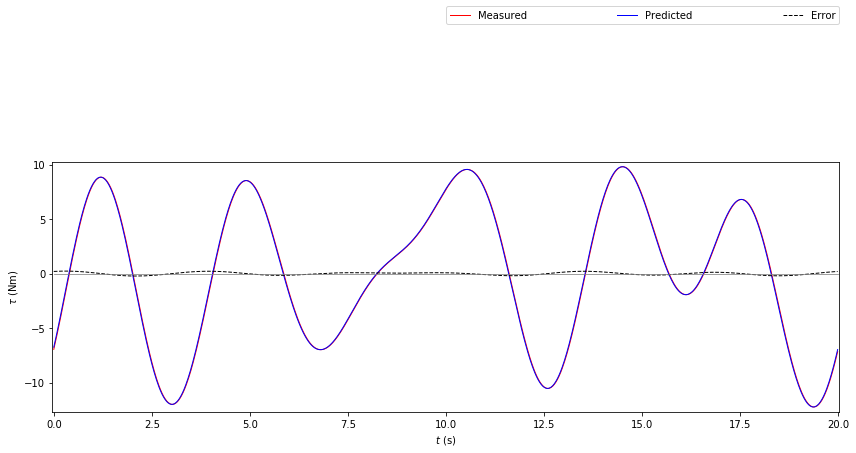

In [366]:
# from support_funcs.regr_data_proc import  plot_meas_pred_tau

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,8]

proc = numpy.load(tmpfolder + 'procdata/' + indentification_traj + '_proc.npz')
t = proc['t']
tau = proc['tau']

tau_p = np.zeros(tau.shape)
tau_ps = W.dot(numpy.matrix(beta_cad))
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof].flatten()

base_freq = 0.05    
trajectory_sampling_rate = 50
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t[:plot_data_num], tau[:plot_data_num, :],
                   tau_p[:plot_data_num, :])

In [367]:
q = proc['q']
dq = proc['dq']
ddq = proc['ddq']

In [368]:
for i in range(20):
    print q[i] ,dq[i], ddq[i], tau[i],tau_p[i]

[2.61095533] [-0.6256688] [-1.1636003] [-6.95234198] [-6.75648242]
[2.59821321] [-0.64834329] [-1.10365262] [-6.63691089] [-6.4374487]
[2.58502967] [-0.66980721] [-1.04253404] [-6.31539585] [-6.11224412]
[2.57142914] [-0.69003765] [-0.98034947] [-5.98801927] [-5.78141718]
[2.55743651] [-0.70901551] [-0.91733018] [-5.65570912] [-5.4462067]
[2.54307697] [-0.72672578] [-0.8535777] [-5.31939164] [-5.10714236]
[2.52837603] [-0.74315304] [-0.78898073] [-4.97884223] [-4.76359065]
[2.51335952] [-0.7582793] [-0.72349218] [-4.63334816] [-4.4152691]
[2.49805364] [-0.77208824] [-0.65732257] [-4.28338768] [-4.06330309]
[2.48248484] [-0.78456925] [-0.59073839] [-3.93054495] [-3.7091242]
[2.46667977] [-0.79571521] [-0.5237909] [-3.57575026] [-3.35298804]
[2.45066519] [-0.80551783] [-0.45637198] [-3.21857185] [-2.99427968]
[2.43446807] [-0.81396708] [-0.38847391] [-2.85851753] [-2.63293331]
[2.41811558] [-0.82105498] [-0.32029538] [-2.49631397] [-2.27001182]
[2.40163497] [-0.82677867] [-0.25210389] [-

### $\beta^{cad}$  Double Check

In [369]:
def  test_lmi_matrix_psd(delta_solution):
    dict_subs = dict(zip(delta, delta_solution))

    test = 'ok'
    for Di in D_blocks:
            m = numpy.matrix(mrepl(Di, dict_subs)).astype(float)
            for v in numpy.linalg.eigvals( m ):
                if v <= 0.0:
                    print(v)
                    test = 'fail'
    print(test)

In [370]:
test_lmi_matrix_psd(delta_cad)

ok


In [371]:
test_mass_matrix_psd(beta_cad)

ok        10000  100%
not ok        0    0%

Seems feasible.


In [372]:
form = '%.4g'

import sympy

table = ListTable()
header = ['', 'Bcad', 'B^', '% std dev B^', 'B*ext']
table.append(header)
for i, b in enumerate(rbt.dyn.baseparms.n()):
    if beta_cad[i].is_Number:
        cad_v = sympy.N(beta_cad[i], 4)
    elif beta_cad[i].is_Symbol:
        cad_v = '---'
    else:
        cad_v = sympy.N(beta_cad[i], 4)
    row = ['%.7s ...'%b if len(str(b)) > 107 else str(b), cad_v]
    row += [form%solutions_beta['beta_ols'][i,0], '%.2g'%analysis['id']['betas']['beta_ols']['sd%'][i,0]]
    row += [form%solutions_beta['beta_starextra'][i,0]]
    table.append(row)
table

,Bcad,B^,% std dev B^,B*ext
L_1zz,5.465,5.464,0.039,5.464
l_1x,0,-0.0004756,75,-0.0004756
l_1y,-0.08000,-0.07983,0.45,-0.07983


## Torque Plot

In [373]:
traj = 'id'
betaname = 'beta_star'

In [374]:
regr_mats = np.load(tmpfolder + 'procdata/' + trajs[traj] + '_regr.npz')
W = np.matrix(regr_mats['W'])
omega = np.matrix(regr_mats['omega'])

regr_mats = np.load(tmpfolder + 'procdata/' + trajs[traj] + '_proc.npz')
t = regr_mats['t']
tau_proc = np.matrix(regr_mats['tau'])

regr_mats = np.load(tmpfolder + 'procdata/' + trajs[traj] + '_raw.npz')
tau_raw = np.matrix(regr_mats['tau'])

In [375]:
beta_solution = np.matrix(np.loadtxt(tmpfolder + 'solutions/%s_%s.dat'%(trajs['id'], betaname))).T

In [376]:
tau = tau_raw

In [377]:
omega_pred = W * beta_solution
tau_pred = omega_pred.reshape( omega_pred.shape[0]/tau.shape[1], tau.shape[1] )
err_pred = tau - tau_pred

In [378]:
joint = 1
firsts = 2000
s=tau_raw.shape[0]

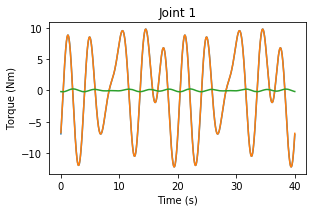

In [379]:
from matplotlib import pyplot as plt
plt.close()

plt.figure(figsize=(12,8))

axes = []
for i in range(tau.shape[1]):
    ax = plt.subplot(3, 3, i+1)
    ax.plot(t[:firsts],tau_raw[:,i][:firsts], label="Measured torque")
    ax.plot(t[:firsts],tau_pred[:,i][:firsts], label="Estimated torque")
    ax.plot(t[:firsts],err_pred[:,i][:firsts], label="Error")
    ax.set_title( "Joint %d"%(i+1) )
    plt.xlabel("Time (s)")
    plt.ylabel("Torque (Nm)")
    axes.append(ax)

plt.tight_layout()

plt.show()

In [392]:
beta_starextra

matrix([[ 5.46444079e+00],
        [-4.75648761e-04],
        [-7.98258055e-02]])

In [393]:
delta_starextra = Pb*beta_starextra + (-Pb*rbt.dyn.Kd+rbt.dyn.Pd)*delta_d_starextra
K = np.matrix(Pb.T+rbt.dyn.Kd*rbt.dyn.Pd.T).astype(float)
delta_starextra_min = np.linalg.pinv(K)*beta_starextra

In [394]:
np.testing.assert_array_almost_equal(K * delta_starextra ,beta_starextra, 10)

In [395]:
for i in range(delta_starextra.shape[0]):
     print 'double ' + repr(rbt.dyn.dynparms[i]) + '    =    ' + repr(delta_starextra[i,0]) + ';'

double L_1xx    =    5773502.69224243;
double L_1xy    =    -6.28135462106671e-6;
double L_1xz    =    0;
double L_1yy    =    5773502.69189660;
double L_1yz    =    0;
double L_1zz    =    5.46444079418025;
double l_1x    =    -0.000475648760565255;
double l_1y    =    -0.0798258054926146;
double l_1z    =    0;
double m_1    =    4.48615778034071;


In [396]:
for i in range(delta_starextra.shape[0]):
     print 'double ' + repr(rbt.dyn.dynparms[i]) + '    =    ' + repr(delta_starextra_min[i,0]) + ';'

double L_1xx    =    0.0;
double L_1xy    =    0.0;
double L_1xz    =    0.0;
double L_1yy    =    0.0;
double L_1yz    =    0.0;
double L_1zz    =    5.464440794180246;
double l_1x    =    -0.0004756487605652551;
double l_1y    =    -0.07982580549261459;
double l_1z    =    0.0;
double m_1    =    0.0;


---------------------------

---------------------------

---------------------------

---------------------------

---------------------------

---------------------------

---------------------------

---------------------------

---------------------------

### (generate readme and notebook preview)

In [3]:
def save_files(): 
    from IPython.display import display, Javascript
    Javascript('IPython.notebook.save_notebook()')
    
    import json
    with open('WAM7 Dynamic Parameter Identification.ipynb', 'r') as f:
        d = json.load(f)
    with open('README.md', 'w') as f:
        f.write(''.join(d['worksheets'][0]['cells'][0]['source']).encode('UTF-8'))
    
    !ipython nbconvert "WAM7 Dynamic Parameter Identification.ipynb" --to html

In [3]:
#save_files()

In [36]:
#!git status

In [37]:
#!git commit -a -m "Add automathic README.md file generator"

In [38]:
#!git push